In [4]:
"""
    Notebook to explore embedding space for members and non-members for few-shot learning to see if any useful trends exist that can be utilized
    by adversary.
"""
# Extension re-loading
%load_ext autoreload
%autoreload 2

In [5]:
import torch as ch
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from distribution_inference.datasets.utils import get_dataset_wrapper
from distribution_inference.config.core import DatasetConfig, RelationConfig
from dataclasses import replace

from distribution_inference.training.utils import load_model
import distribution_inference.models.contrastive as models_contrastive
from distribution_inference.attacks.blackbox.utils import get_relation_preds
from distribution_inference.training.relation_net import validate_epoch
from distribution_inference.attacks.blackbox.utils import image_similarities

from tqdm import tqdm
import torchvision.transforms as transforms
import kornia.augmentation as kor_aug

# Set DPI to 300 for better quality
plt.rcParams['figure.dpi'] = 200

In [6]:
@ch.no_grad()
def collect_embeddings(model, loader, squeeze: bool = True):
    """
        Collect embeddings for a given model and loader
    """
    embeddings, labels = [], []
    for batch in tqdm(loader, desc="Collecting embeddings"):
        embed = model(batch[0].cuda(), embedding_mode=True).detach().cpu().numpy()
        embeddings.append(embed)
        labels.append(batch[1].numpy())
    embeddings = np.concatenate(embeddings, axis=0)
    # Flatten out embeddings:
    if squeeze:
        embeddings = embeddings.reshape(embeddings.shape[0], -1)
    labels = np.concatenate(labels, axis=0)
    return embeddings, labels

In [7]:
def look_at_metrics(embeds):
    """
        Helper function to look at the metrics studied in https://arxiv.org/abs/2203.02077
        to see if they seem to be of use
    """
    centroid = np.mean(embeds, axis=0)
    # Distances from all points to centroid
    dists = np.linalg.norm(embeds - centroid, axis=1)
    dists = dists.mean()
    # Distances from all points to each other
    dists2 = np.linalg.norm(embeds[:, None] - embeds[None, :], axis=2)
    dists2 = dists2.mean()
    return dists, dists2

In [5]:
@ch.no_grad()
def look_at_relational_metrics(model, embeds):
    """
        Similar to looking at metrics, but using the model explicitly to compute distances,
        instead of L2 norm.
    """
    embeds_ = ch.from_numpy(embeds)
    centroid = ch.mean(embeds_, 0).unsqueeze(0).repeat(len(embeds), 1, 1, 1)
    combined = ch.cat((centroid, embeds_), 1)
    dists = model(combined.cuda(), embedding_mode=False).detach().mean().cpu().item()
    # Distances from all points to each other
    dists2 = []
    for i in range(embeds_.shape[0]-1):
        others = embeds_[i+1:]
        this = embeds_[i].unsqueeze(0).repeat(others.shape[0], 1, 1, 1)
        combined = ch.cat((others, this), 1)
        dists_ = model(combined.cuda(), embedding_mode=False).detach()
        dists2.extend(dists_)
    dists2 = ch.mean(ch.cat(dists2)).cpu().item()
    return 1 - dists, 1 - dists2

In [6]:
def embedding_study(ds_adv, ds_victim,
                    victim_model,
                    batch_size: int = 128,
                    skip_plot: bool = False,
                    n_people: int = 5):
    """
        Look at embedding distances between clusters of pairs of images of people.
        Intiution: member subjects would be clustered more tightly.
    """
    # Sample from train_people to pick random people
    train_people = np.random.choice(train_people, size=n_people, replace=False)

    # Get loader for victim that contains train people
    loader_members = ds_victim.get_specified_loader(train_people, shuffle=True, batch_size=batch_size)
    # Get loader for adversary (use test people for now)
    _, loader_nonmembers = ds_adv.get_loaders(shuffle=True, batch_size=batch_size, primed_for_training=False)

    # Collect embeddings
    member_embeds, member_labels = collect_embeddings(victim_model, loader_members)
    nonmember_embeds, nonmember_labels = collect_embeddings(victim_model, loader_nonmembers)

    def _within(x, y):
        centroids = []
        spreads = []
        for y_ in np.unique(y):
            selected = x[y == y_]
            centroid = np.mean(selected, axis=0)
            dists = np.linalg.norm(selected - centroid, axis=1).mean()
            centroids.append(centroid)
            spreads.append(dists)
        return np.array(centroids), np.mean(spreads)

    member_wise_centre, member_wise_spread = _within(member_embeds, member_labels)
    nonmember_wise_centre, nonmember_wise_spread = _within(nonmember_embeds, nonmember_labels)

    # Look at pair-wise distances between elements of member_wise_centre
    member_centre_dist = []
    for i in range(member_wise_centre.shape[0] - 1):
        # print(member_wise_centre[i].shape, member_wise_centre[i+1:].shape)
        member_centre_dist.extend(np.linalg.norm(member_wise_centre[i] - member_wise_centre[i+1:], axis=1))
    member_centre_dist = np.array(member_centre_dist)
    # Look at pair-wise distances between elements of nonmember_wise_centre
    nonmember_centre_dist = []
    for i in range(nonmember_wise_centre.shape[0] - 1):
        nonmember_centre_dist.extend(np.linalg.norm(nonmember_wise_centre[i] - nonmember_wise_centre[i+1:], axis=1))
    nonmember_centre_dist = np.array(nonmember_centre_dist)
    # Look at distance between elements of member_wise_centre and nonmember_wise_centre
    member_nonmember_centre_dist = []
    for i in range(member_wise_centre.shape[0]):
        member_nonmember_centre_dist.extend(np.linalg.norm(
            member_wise_centre[i] - nonmember_wise_centre, axis=1))
    member_nonmember_centre_dist = np.array(member_nonmember_centre_dist)
    
    print(f"Member distances: {member_centre_dist.mean()}, spreads: {member_wise_spread}")
    print(f"Nonmember distances: {nonmember_centre_dist.mean()}, spreads: {nonmember_wise_spread}")
    print(f"Member-nonmember distances: {member_nonmember_centre_dist.mean()}")

    return member_centre_dist, nonmember_centre_dist, member_nonmember_centre_dist

In [7]:
def relational_aug_experiment(ds_adv, ds_victim,
                          victim_model,
                          batch_size: int = 128,
                          n_people: int = 5,
                          n_support: int = 5,
                          n_way: int = 5,
                          n_times: int = 5,
                          normalized: bool = False,
                          corruption: float = 0.10):
    """
        Look at change in model predictions when query images are replaced with augmented verions of the 
        same image (based on random erasing). Idea: member subjects might be slightly "memorized" by model
        and it might retain higher accuracy for such subjects.
    """
    # Sample from train_people to pick random people
    train_people = np.random.choice(train_people, size=n_people, replace=False)

    # Get loader for victim that contains train people
    loader_members = ds_victim.get_specified_loader(
        train_people, shuffle=True, batch_size=batch_size)
    # Get loader for adversary (use test people for now)
    _, loader_nonmembers = ds_adv.get_loaders(
        shuffle=True, batch_size=batch_size, primed_for_training=False)

    # Crop-based transform
    transform = kor_aug.RandomErasing(scale=(corruption, corruption + 0.05), p=1)

    def _collect_matching(loader):
        mapping = {}
        for batch in loader:
            img = batch[0]
            lbl = batch[1]
            for i, l in enumerate(lbl):
                l_ = l.item()
                if l_ not in mapping:
                    mapping[l_] = []
                mapping[l_].append(img[i])
        for k in mapping.keys():
            mapping[k] = ch.stack(mapping[k])
        return mapping
    
    def kl_div(x, y):
        eps = 1e-6
        x_ = x + eps
        y_ = y + eps
        # Compute kl divergence
        return (x_ * np.log(x_ / y_)).sum()

    def _treatment(map):
        relation_vals = []
        for k, v in tqdm(map.items(), desc="Collecting relation values"):
            # Create support
            other_people = list(set(map.keys()) - {k})
            other_people = np.random.choice(other_people, size=n_way - 1, replace=False)
            this_images = v
            support_images = [this_images[:n_support].cuda()]
            for o in other_people:
                random_choice = np.random.choice(
                    len(map[o]), size=n_support, replace=False)
                # Randomly n_support from map[o]
                support = map[o][random_choice]
                support_images.append(support.cuda())

            # Use last n_support images as query
            query_images = this_images[n_support:]
            n_query = len(query_images)
            # Get preds on untransformed query images
            with ch.no_grad():
                og_relation_values = get_relation_preds(support_images, query_images.cuda(), victim_model).cpu()
                if normalized:
                    og_relation_values = ch.softmax(og_relation_values, 1)
                og_relation_values = og_relation_values.numpy()
            
            # Apply transform n_times to each query image
            query_images = (query_images + 1) / 2
            collected = []
            for i in range(n_times):
                collected.append(transform(query_images))
            query_images = ch.cat(collected, 0)
            # query shape: (n_times * n_query, 3, 96, 96)
            # Bring back to (-1, 1) normalization
            query_images = ((query_images - 0.5) * 2)

            with ch.no_grad():
                relation_values = get_relation_preds(support_images, query_images.cuda(), victim_model).cpu()
                if normalized:
                    relation_values = ch.softmax(relation_values, 1)
                relation_values = relation_values.numpy()
                
            # Shape: (n_times * n_query, n_way)
            relation_values = relation_values.reshape(n_query, n_times, n_way)
            # Get mean KL divergence between og_relation_values (per image), and each transformed version
            inside = []
            for i in range(n_query):
                relations = relation_values[i]
                og_relations = og_relation_values[i]
                inside.append(np.mean([kl_div(og_relations, relations[j]) for j in range(n_times)]))
            relation_vals.append(np.mean(inside))

        return np.array(relation_vals)

    member_map = _collect_matching(loader_members)
    nonmember_map = _collect_matching(loader_nonmembers)

    member_vals = _treatment(member_map)
    nonmember_vals = _treatment(nonmember_map)

    return member_vals, nonmember_vals


In [8]:
def output_analysis(ds_adv, ds_victim,
                     victim_model, train_people,
                    batch_size: int = 128,
                    n_people: int = 5,
                    n_support: int = 5,
                    n_way: int = 5):
    """
        Pure inspection of model predictions
    """
    # Sample from train_people to pick random people
    train_people = np.random.choice(train_people, size=n_people, replace=False)

    # Get loader for victim that contains train people
    loader_members = ds_victim.get_specified_loader(
        train_people, shuffle=True, batch_size=batch_size)
    # Get loader for adversary (use test people for now)
    _ , loader_nonmembers = ds_adv.get_loaders(
        shuffle=True, batch_size=batch_size, primed_for_training=False)

    def _collect_matching(loader):
        mapping = {}
        for batch in tqdm(loader, desc="Split into people"):
            img = batch[0]
            lbl = batch[1]
            for i, l in enumerate(lbl):
                l_ = l.item()
                if l_ not in mapping:
                    mapping[l_] = []
                mapping[l_].append(img[i])
        for k in mapping.keys():
            mapping[k] = ch.stack(mapping[k])
        return mapping

    def _treatment(map):
        relation_vals = []
        similarities = []
        for k, v in tqdm(map.items(), desc="Collecting relation values"):
            embeds_person = victim_model(v.cuda(), embedding_mode=True).detach().cpu()
            for i in range(len(embeds_person) - 1):
                others = embeds_person[i+1:]
                repeated_i = embeds_person[i].unsqueeze(0).repeat(len(others), 1, 1, 1)
                # Also keep track of cosine similarity
                repeated_img_i = v[i].view(1, -1).repeat(len(others), 1)
                others_img = v[i+1:].view(len(others), -1)
                cosine_sim = ch.cosine_similarity(0.5 + repeated_img_i/2, 0.5 + others_img/2).cpu().detach().numpy()
                similarities.append(cosine_sim)
                # combined = ch.cat((others, repeated_i), 1)
                combined = ch.cat((repeated_i, others), 1)
                wanted_relation_values = victim_model(combined.cuda(), embedding_mode=False)
                relation_val = wanted_relation_values.cpu().detach().numpy()
                relation_vals.append(relation_val[:, 0])
        relation_vals = np.concatenate(relation_vals)
        similarities = np.concatenate(similarities)
        return np.array([relation_vals, similarities])

    member_map = _collect_matching(loader_members)
    nonmember_map = _collect_matching(loader_nonmembers)

    member_vals = _treatment(member_map)
    nonmember_vals = _treatment(nonmember_map)

    return member_vals, nonmember_vals

In [9]:
def simulation(ds_adv, ds_victim,
               victim_model, train_people,
               batch_size: int = 128,
               n_people: int = 5,
               n_support: int = 5,
               n_per_person: int = 10):
    """
        Generate features as would be used by meta-classifier.
    """
    # Sample from train_people to pick random people
    train_people = np.random.choice(train_people, size=n_people, replace=False)

    # Get loader for victim that contains train people
    loader_members = ds_victim.get_specified_loader(
        train_people, shuffle=True, batch_size=batch_size)
    # Get loader for adversary (use test people for now)
    _ , loader_nonmembers = ds_adv.get_loaders(
        shuffle=True, batch_size=batch_size, primed_for_training=False)

    def _collect_matching(loader):
        mapping = {}
        for batch in tqdm(loader, desc="Split into people"):
            img = batch[0]
            lbl = batch[1]
            for i, l in enumerate(lbl):
                l_ = l.item()
                if l_ not in mapping:
                    mapping[l_] = []
                mapping[l_].append(img[i])
        for k in mapping.keys():
            mapping[k] = ch.stack(mapping[k])
        return mapping

    def _treatment(map):
        relation_vals = []
        similarities = []
        for k, v in tqdm(map.items(), desc="Generating features"):
            embeds_person = victim_model(v.cuda(), embedding_mode=True).detach().cpu()
            # Pick first n_support for gallery
            gallery_embeds = ch.mean(embeds_person[:n_support], 0).view(1, *embeds_person.shape[1:]).repeat(n_per_person, 1, 1, 1)
            # Look at mean cosine similarities between each other query image
            similarity = image_similarities(v[:n_support], v[n_support:])
            # Rank by similarities, pick top ones
            wanted = np.argsort(similarity)[::-1][:n_per_person] + n_support
            similarities.append(similarity[wanted - n_support])
            # Get relation-model scores
            combined = ch.cat((gallery_embeds, embeds_person[wanted]), 1)
            wanted_relation_values = victim_model(combined.cuda(), embedding_mode=False)
            relation_val = wanted_relation_values.cpu().detach().numpy()
            relation_vals.append(relation_val[:, 0])
        relation_vals = np.concatenate(relation_vals)
        similarities = np.concatenate(similarities)
        return np.array([relation_vals, similarities])

    member_map = _collect_matching(loader_members)
    nonmember_map = _collect_matching(loader_nonmembers)

    member_vals = _treatment(member_map)
    nonmember_vals = _treatment(nonmember_map)

    return member_vals, nonmember_vals

In [10]:
def relational_experiment(ds_adv, ds_victim,
                          victim_model, train_people,
                          batch_size: int = 128,
                          n_people: int = 5,
                          n_support: int = 5,
                          n_way: int = 5,
                          collect_ind: bool = False,
                          normalized_preds: bool = False):
    """
        Look at model relation outputs between query images and support images for ground truth.
        Since this is the feature vector used in Face-Audit, should have some useful signal beneath it?
    """
    # Sample from train_people to pick random people
    train_people = np.random.choice(train_people, size=n_people, replace=False)

    # Get loader for victim that contains train people
    loader_members = ds_victim.get_specified_loader(
        train_people, shuffle=True, batch_size=batch_size)
    
    # Get loader for adversary (use test people for now)
    loader_nonmembers, _ = ds_adv.get_loaders(
        shuffle=True, batch_size=batch_size, primed_for_training=False)

    def _collect_matching(loader):
        mapping = {}
        for batch in loader:
            img = batch[0]
            lbl = batch[1]
            for i, l in enumerate(lbl):
                l_ = l.item()
                if l_ not in mapping:
                    mapping[l_] = []
                mapping[l_].append(img[i])
        for k in mapping.keys():
            mapping[k] = ch.stack(mapping[k])
        return mapping

    def _treatment(map):
        relation_vals = []
        for k, v in tqdm(map.items(), desc="Collecting relation values"):
            # Pick n_way - 1 other people randomly from map.keys()
            other_people = list(set(map.keys()) - {k})
            other_people = np.random.choice(other_people, size=n_way - 1, replace=False)
            this_images = v
            # Pick first n_support images from this_images
            if collect_ind:
                support_images = [x.unsqueeze(0).cuda() for x in this_images[:n_support]]
            else:
                support_images = [this_images[:n_support].cuda()]
            for o in other_people:
                random_choice = np.random.choice(len(map[o]), size=n_support, replace=False)
                # Randomly n_support from map[o]
                support = map[o][random_choice]
                if collect_ind:
                    for x in support:
                        support_images.append(x.unsqueeze(0).cuda())
                else:
                    support_images.append(support.cuda())
            query_images = this_images[n_support:].cuda()
            relation_values = get_relation_preds(support_images, query_images, victim_model)
            if collect_ind:
                wanted_relation_values = relation_values[:, :n_support]
            else:
                if normalized_preds:
                    relation_values = ch.softmax(relation_values, dim=1)
                #wanted_relation_values = relation_values[:, 0]
                wanted_relation_values = ch.stack((relation_values[:, 0], ch.mean(relation_values[:, 1:], 1)), 1)
                # wanted_relation_values = ch.stack(((1 - relation_values[:, 0]) ** 2, ch.mean(relation_values[:, 1:] ** 2, 1)), 1)
                
                #largest_otherwise = ch.max(relation_values[:, 1:], dim=1).values
                #wanted_relation_values -= largest_otherwise

            relation_vals.extend(wanted_relation_values.cpu().numpy())
        return np.array(relation_vals)

    member_map = _collect_matching(loader_members)
    nonmember_map = _collect_matching(loader_nonmembers)

    member_vals = _treatment(member_map)
    nonmember_vals = _treatment(nonmember_map)

    return member_vals, nonmember_vals

In [114]:
def experiment(ds_adv, ds_victim,
               victim_model,
               train_people,
               batch_size: int = 128,
               n_people: int = 5,
               skip_plot: bool = False,
               tsne_dim: int = 2,
               use_relation: bool = False):
    """
        Analysis of embeddings in projected space to see if any useful trends emerge.
    """
    # Sample from train_people to pick random people
    train_people = np.random.choice(train_people, size=n_people, replace=False)

    # Get loader for victim that contains train people
    loader_members = ds_victim.get_specified_loader(train_people, shuffle=True, batch_size=batch_size)
    # Get loader for adversary (use test people for now)
    loader_nonmembers, _ = ds_adv.get_loaders(shuffle=True, batch_size=batch_size, primed_for_training=False)

    # Collect embeddings
    member_embeds, member_labels = collect_embeddings(victim_model, loader_members, squeeze = not use_relation)
    nonmember_embeds, nonmember_labels = collect_embeddings(victim_model, loader_nonmembers, squeeze = not use_relation)

    # Pick n_people random people from nonmember_labels
    random_nonmembers = np.random.choice(np.unique(nonmember_labels), size=n_people, replace=False)
    # Keep only embeddings for these people
    nonmember_embeds = nonmember_embeds[np.isin(nonmember_labels, random_nonmembers)]
    nonmember_labels = nonmember_labels[np.isin(nonmember_labels, random_nonmembers)]

    # Gather some metrics
    if use_relation:
        member_metrics = np.array([look_at_relational_metrics(victim_model, member_embeds[member_labels == i]) for i in np.unique(member_labels)])
        nonmember_metrics = np.array([look_at_relational_metrics(victim_model, nonmember_embeds[nonmember_labels == i]) for i in np.unique(nonmember_labels)])
    else:
        member_metrics = np.array([look_at_metrics(member_embeds[member_labels == i]) for i in np.unique(member_labels)])
        nonmember_metrics = np.array([look_at_metrics(nonmember_embeds[nonmember_labels == i]) for i in np.unique(nonmember_labels)])

    if skip_plot:
        return member_metrics, nonmember_metrics

    # Create colors array such that each person has a unique color
    unique_colors = np.unique(np.concatenate([member_labels, nonmember_labels]))
    num_colors = len(unique_colors)
    # Create colormap
    cmap = plt.cm.get_cmap('tab10', num_colors)
    # Create color array
    member_labels = [cmap(np.where(unique_colors == i)[0][0]) for i in member_labels]
    nonmember_labels = [cmap(np.where(unique_colors == i)[0][0]) for i in nonmember_labels]

    # Combine embeddings
    embeds = np.concatenate([member_embeds, nonmember_embeds], axis=0)

    # Get t-SNE embeddings
    tsne = TSNE(n_components=tsne_dim, random_state=2023)
    tsne_embeds = tsne.fit_transform(embeds)

    # Plot member-corresponding data with marker as 'x'
    if tsne_dim == 2:
        plt.scatter(tsne_embeds[:len(member_labels), 0], tsne_embeds[:len(member_labels), 1], c=member_labels, marker='x', cmap='tab10')
        # Plot nonmember-corresponding data with marker as 'o'
        plt.scatter(tsne_embeds[len(member_labels):, 0], tsne_embeds[len(member_labels):, 1], c=nonmember_labels, marker='o', cmap='tab10')
    elif tsne_dim == 3:
        ax = plt.axes(projection='3d')
        # creating the plot
        # creating the plot
        ax.scatter3D(tsne_embeds[:len(member_labels), 0], tsne_embeds[:len(member_labels), 1], tsne_embeds[:len(member_labels), 2], c=member_labels, marker='x') #, cmap='tab10')
        ax.scatter3D(tsne_embeds[len(member_labels):, 0], tsne_embeds[len(member_labels):, 1], tsne_embeds[len(member_labels):, 2], c=nonmember_labels, marker='o') #, cmap='tab10')
        ax.set_title("3D t-SNE")
        ax.set_xlabel('x-axis')
        ax.set_ylabel('y-axis')
        ax.set_zlabel('z-axis')
    else:
        raise ValueError(f"tsne_dim must be 2 or 3, got {tsne_dim}")

    plt.show()

    return member_metrics, nonmember_metrics

In [1]:
def hardness_tester(ds_adv, ds_victim,
                    victim_model, train_people,
                    batch_size: int = 128,
                    n_people: int = 5,
                    n_support: int = 5,
                    n_per_person: int = 10):
    # Sample from train_people to pick random people
    train_people = np.random.choice(train_people, size=n_people, replace=False)

    # Get loader for victim that contains train people
    loader_members = ds_victim.get_specified_loader(
        train_people, shuffle=True, batch_size=batch_size)
    # Get loader for adversary (use test people for now)
    _ , loader_nonmembers = ds_adv.get_loaders(
        shuffle=True, batch_size=batch_size, primed_for_training=False)

    def _collect_matching(loader):
        mapping = {}
        for batch in tqdm(loader, desc="Split into people"):
            img = batch[0]
            lbl = batch[1]
            for i, l in enumerate(lbl):
                l_ = l.item()
                if l_ not in mapping:
                    mapping[l_] = []
                mapping[l_].append(img[i])
        for k in mapping.keys():
            mapping[k] = ch.stack(mapping[k])
        return mapping

    def _treatment(map, others_map=None):
        # Idea is to first find n-closest prorotypes per query image, and then
        # compare model outputs for those prototypes v/s actual matching prototype
        
        # Compute prototypes for given people
        map_prototypes, nonmap_prototypes = {}, {}
        for k, v in tqdm(map.items(), desc="Computing prototypes"):
            map_prototypes[k] = ch.mean(victim_model(v[:n_support].cuda(), embedding_mode=True).detach(), 0).cpu()
            
        # If given explicit "other" non-member people, compute for them as well
        if others_map is not None:
            for k, v in tqdm(others_map.items(), desc="Computing prototypes"):
                nonmap_prototypes[k] = ch.mean(victim_model(v[:n_support].cuda(), embedding_mode=True).detach(), 0).cpu()
        
        # Now, compute embeddings for other people and for each query image, find closest matches
        # According to relation-net model, and pick the best n_people-1 out of them
        scores = []
        for k, v in tqdm(map.items(), desc="Generating features"):
            embeds_q = victim_model(v[n_support:].cuda(), embedding_mode=True).detach().cpu()
            # Get relation-net model outputs for each query with all other people
            if others_map is None:
                other_prototypes = ch.stack([v for k_, v in map_prototypes.items() if k_ != k])
            else:
                other_prototypes = ch.stack(list(nonmap_prototypes.values()))
            q_vals = []
            for embed_q in embeds_q:
                embed_q_repeat = embed_q.unsqueeze(0).repeat(len(other_prototypes), 1, 1, 1)
                combined = ch.cat((other_prototypes, embed_q_repeat), 1)
                relation_vals = victim_model(combined.cuda(), embedding_mode=False).detach().cpu()
                # Pick best n_people - 1 and get their corresponding scores
                best_vals = ch.topk(relation_vals[:, 0], k=n_people-1).values
                q_vals.append(best_vals)
            q_vals = ch.stack(q_vals) #n, p-1
            # Make note of score with actual prototype
            prototype = ch.mean(victim_model(v[:n_support].cuda(), embedding_mode=True).detach(), 0).cpu()
            prototype = prototype.unsqueeze(0).repeat(len(embeds_q), 1, 1, 1)
            # print(prototype.shape, embeds_q.shape)
            combined = ch.cat((prototype, embeds_q), 1)
            actual_vals = victim_model(combined.cuda(), embedding_mode=False).detach().cpu()
            # print(actual_vals.shape, q_vals.shape)
            scores_ = ch.cat((actual_vals, q_vals), 1).numpy()
            scores.append(scores_)
        return np.array(scores)

    member_map = _collect_matching(loader_members)
    nonmember_map = _collect_matching(loader_nonmembers)

    member_vals = _treatment(member_map, nonmember_map)
    nonmember_vals = _treatment(nonmember_map)

    return member_vals, nonmember_vals

In [109]:
def recovery_test(ds_adv, ds_victim,
                  victim_model, train_people,
                  batch_size: int = 128,
                  n_people: int = 5,
                  n_support: int = 5):
    # Sample from train_people to pick random people
    train_people = np.random.choice(train_people, size=n_people, replace=False)

    # Get loader for victim that contains train people
    loader_members = ds_victim.get_specified_loader(
        train_people, shuffle=True, batch_size=batch_size)
    # Get loader for adversary (use test people for now)
    _ , loader_nonmembers = ds_adv.get_loaders(
        shuffle=True, batch_size=batch_size, primed_for_training=False)

    def _collect_matching(loader):
        mapping = {}
        for batch in tqdm(loader, desc="Split into people"):
            img = batch[0]
            lbl = batch[1]
            for i, l in enumerate(lbl):
                l_ = l.item()
                if l_ not in mapping:
                    mapping[l_] = []
                mapping[l_].append(img[i])
        for k in mapping.keys():
            mapping[k] = ch.stack(mapping[k])
        return mapping

    def recovery(map):
        # Compute prototypes for given people
        map_prototypes, nonmap_prototypes = {}, {}
        for k, v in tqdm(map.items(), desc="Computing prototypes"):
            map_prototypes[k] = ch.mean(victim_model(v[:n_support].cuda(), embedding_mode=True).detach(), 0).cpu()
        
        # Perform gradient descent to find image that maximizes matching accuracy to given prototype image
        recons, scores = [], []
        steps = 0
        for k, v in tqdm(map.items(), desc="Processing people",total=n_people):
            n_steps_optim = 1000
            step_size = 10.0
            # Pick some other oerson's image as starting point
            other_people = [x for x in map.keys() if x != k]
            random_image = map[np.random.choice(other_people)][0].unsqueeze(0).cuda()

            # random_image = ch.rand_like(v[0]).unsqueeze(0).cuda()
            # random_image = (random_image - 0.5) / 0.5

            prototype = map_prototypes[k].unsqueeze(0).cuda()
            for step in range(n_steps_optim):
                random_var = random_image.clone()
                random_var.requires_grad_(True)
                
                victim_model.zero_grad()
                embed = victim_model(random_var, embedding_mode=True)
                combined = ch.cat((prototype, embed), 1)
                relation_val = victim_model(combined, embedding_mode=False)
                mse = ch.nn.MSELoss()
                loss = (1 - relation_val)**2
                loss.backward()
                perturbation = step_size * random_var.grad
                with ch.no_grad():
                    random_image.data -= perturbation.data
                    random_image.data = ch.clip(random_image.data, -1, 1)
                
            recons.append(random_image.data[0].clone().cpu().numpy())
            scores.append(loss.mean().item())
            steps += 1
            if steps >= n_people:
                break
        return np.array(recons), np.array(scores)

    member_map = _collect_matching(loader_members)
    nonmember_map = _collect_matching(loader_nonmembers)

    member_recons = recovery(member_map)
    nonmember_recons = recovery(nonmember_map)

    return member_recons, nonmember_recons

In [13]:
def test_acc(ds_adv, ds_vic, victim_model):
    # Get loader for adversary (use test people for now)
    _, loader = ds_adv.get_loaders(
        shuffle=True, batch_size=1)
    loss, acc = validate_epoch(loader, victim_model,
                               n_way=5, k_shot=5, num_query=5,
                               verbose=True)
    return loss, acc.item()

In [9]:
model_paths = [
    "/p/adversarialml/as9rw/models_celeba_person/80_20_split/scnn_relation/victim/1/1.0/5_0.9272.ch",
]

rel_config  = RelationConfig(n_way=5, k_shot=5, num_query_train=5, num_query_test=5, test_num_task=80)
base_config = DatasetConfig(name="celeba_person", prop=1, classify=None,
                            split="victim", value=False, augment=False, relation_config=rel_config)
adv_config = replace(base_config, split="adv")

# Get dataset wrapper
ds_wrapper_class = get_dataset_wrapper("celeba_person")

# Create DS objects
ds_vic = ds_wrapper_class(base_config)
ds_adv = ds_wrapper_class(adv_config)

In [10]:
index = -1

In [11]:
# Load victim model
victim_model = models_contrastive.SCNNFaceAudit()
victim_model, (train_people, _) = load_model(
    victim_model, path=model_paths[index], on_cpu=True)
victim_model.cuda()
victim_model.eval()
print("Loaded!")

Loaded!


In [ ]:
test_acc(ds_adv, ds_vic, model_paths[index])

In [ ]:
mem, nonmem = [], []
corruptions = [0.05, 0.1, 0.15, 0.2]
for corr in corruptions: 
    c_mem, c_nonmem = relational_aug_experiment(ds_adv, ds_vic, model_paths[index], n_people=50, n_times=10, normalized=False, corruption=corr)
    mem.append(c_mem)
    nonmem.append(c_nonmem)
mem = np.array(mem)
nonmem = np.array(nonmem)

In [ ]:
plt.hist(nonmem[3], bins=7, alpha=0.5, label="Non-members", density=True)
plt.hist(mem[3], bins=7, alpha=0.5, label="Members", density=True) 
plt.legend()

In [ ]:
mem, nonmem = hardness_tester(ds_adv, ds_vic, victim_model, train_people, n_people=30)

In [ ]:
# mem_ = mem[0]
# nonmem_ = nonmem[15]
# plt.scatter(nonmem_[:, 0], np.max(nonmem_[:, 1:], 1), label="Non-member", color="C0", alpha=0.75)
# plt.scatter(mem_[:, 0], np.max(mem_[:, 1:], 1), label="Member", color="C1", alpha=0.75)
# plt.legend()

# print(mem_[:, 0] - np.max(mem_[:, 1:], 1))
# print(nonmem_[:, 0] - np.max(nonmem_[:, 1:], 1))

mem_all, nonmem_all = [], []
for mem_ in mem:
    # mem_all.extend(mem_[:, 0] - np.max(mem_[:, 1:], 1))
    mem_all.append(np.stack((mem_[:, 0], np.max(mem_[:, 1:], 1))))

for nonmem_ in nonmem:
    # nonmem_all.extend(nonmem_[:, 0] - np.max(nonmem_[:, 1:], 1))
    nonmem_all.append(np.stack((nonmem_[:, 0], np.max(nonmem_[:, 1:], 1))))

# plt.hist(nonmem_all, bins=51, alpha=0.5, label="Non-members", density=True)
# plt.hist(mem_all, bins=51, alpha=0.5, label="Members", density=True)
# plt.xlim(-5e3, 5e3)
# plt.legend()

mem_all = np.concatenate(mem_all, 1).T
nonmem_all = np.concatenate(nonmem_all, 1).T

plt.scatter(nonmem_all[:, 0], nonmem_all[:, 1], label="Non-member", color="C0", alpha=0.75)
plt.scatter(mem_all[:, 0], mem_all[:, 1], label="Member", color="C1", alpha=0.75)
plt.legend()

In [ ]:
mem, nonmem = output_analysis(ds_adv, ds_vic, victim_model, train_people, n_people=20)

In [ ]:
plt.scatter(nonmem[0], nonmem[1], label="Non-member", color="C0", alpha=0.75)
plt.scatter(mem[0], mem[1], label="Member", color="C1", alpha=0.75)
plt.legend()

In [110]:
mem, nonmem = recovery_test(ds_adv, ds_vic, victim_model, train_people, n_people=2)

Processing people:  50%|██████████████████████████████████████████████▌                                              | 1/2 [00:15<00:15, 15.36s/it]


In [111]:
mem[1], nonmem[1]

(array([4.57629139e-05, 2.93980411e-05]),
 array([4.87121069e-05, 8.50397282e-06]))

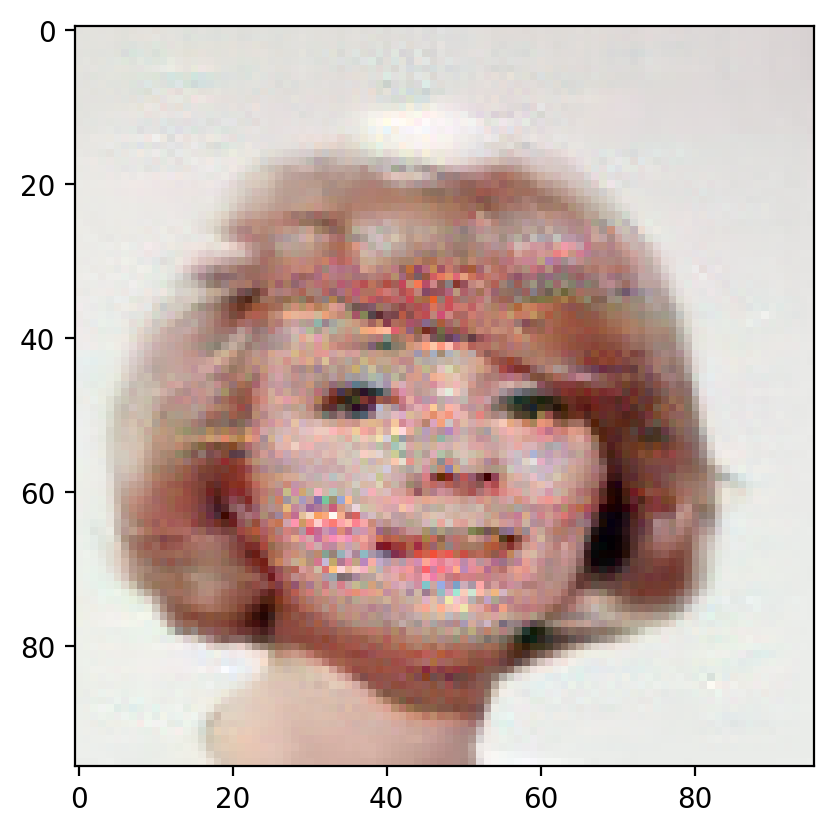

In [112]:
z = 0.5 + mem[0][0] * 0.5
plt.imshow(np.transpose(z, (1, 2, 0)))

In [29]:
mem, nonmem = simulation(ds_adv, ds_vic, victim_model, train_people, n_people=10)

Generating features: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 94.34it/s]


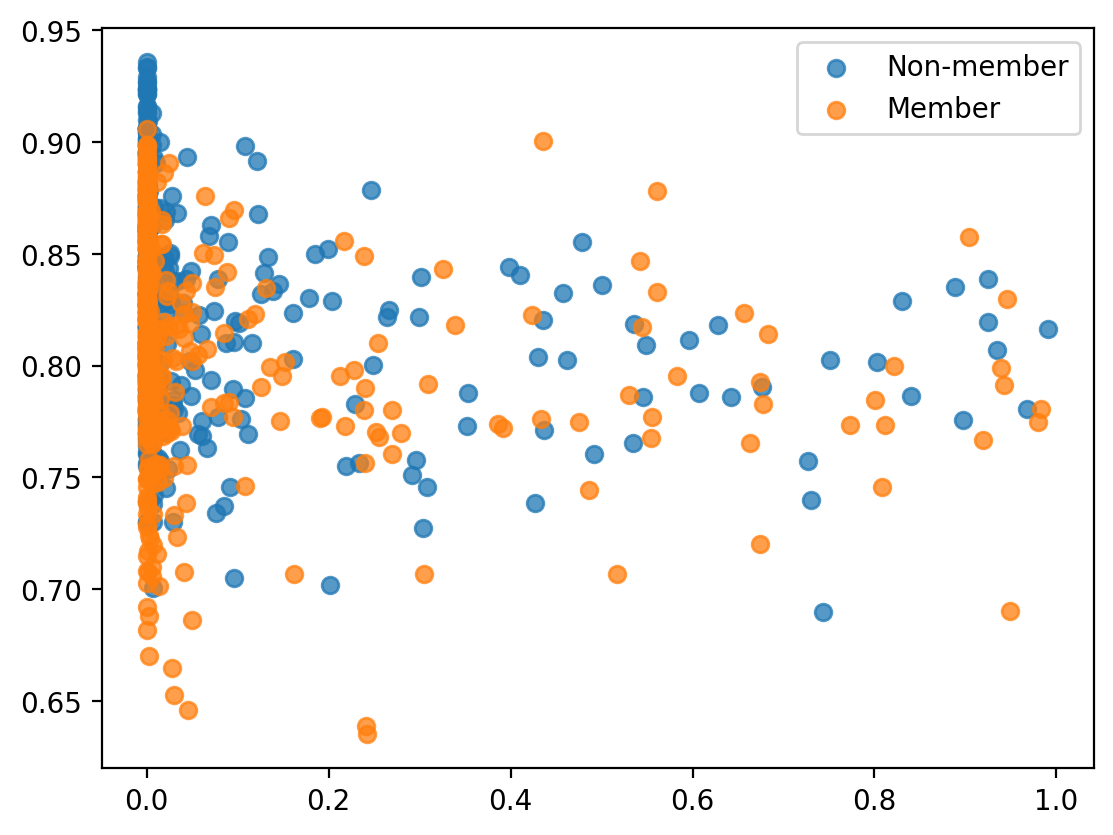

In [23]:
plt.scatter((1 - nonmem[0]) ** 2, nonmem[1], label="Non-member", color="C0", alpha=0.75)
plt.scatter((1 - mem[0]) ** 2, mem[1], label="Member", color="C1", alpha=0.75)
plt.legend()

In [ ]:
plt.scatter(nonmem[0], nonmem[1], label="Non-member", color="C0", alpha=0.75)
plt.scatter(mem[0], mem[1], label="Member", color="C1", alpha=0.75)
plt.legend()

In [ ]:
plt.hist(nonmem[0], bins=21, alpha=0.5, label="Non-members", density=True)
plt.hist(mem[0], bins=21, alpha=0.5, label="Members", density=True)
plt.legend()

In [ ]:
plt.hist(nonmem[0] * nonmem[1], bins=21, alpha=0.5, label="Non-members", density=True)
plt.hist(mem[0] * mem[1], bins=21, alpha=0.5, label="Members", density=True)
plt.legend()

In [ ]:
intra_mem, intra_nonmem, inter = embedding_study(ds_adv, ds_vic, model_paths[index], n_people=50)

In [ ]:
plt.hist(inter, bins=11, alpha=0.5, label="Inter", density=True)
plt.hist(intra_nonmem, bins=11, alpha=0.5, label="Non-members", density=True)
plt.hist(intra_mem, bins=11, alpha=0.5, label="Members", density=True)
plt.legend()

In [ ]:
plt.hist(nonmem, bins=11, alpha=0.5, label="Non-members")
plt.hist(mem, bins=11, alpha=0.5, label="Members")
plt.legend()

In [ ]:
mem, nonmem = relational_experiment(
    ds_adv, ds_vic, victim_model, train_people,
    n_people=40, normalized_preds=False)

In [ ]:
picked = (0, 1)
plt.scatter(nonmem[:, picked[0]], nonmem[:, picked[1]], label="Non-member", color="C0", alpha=0.75)
plt.scatter(mem[:, picked[0]], mem[:, picked[1]], label="Member", color="C1", alpha=0.75)
plt.xlabel("Output for matching-case")
plt.ylabel("Output for non-matching case")
plt.legend()

In [ ]:
plt.hist(nonmem[:, 1] + nonmem[:, 0], bins=11, alpha=0.5, label="Non-members")
plt.hist(mem[:, 1] + mem[:, 0], bins=11, alpha=0.5, label="Members")
plt.legend()

In [ ]:
# for creating a responsive plot
# %matplotlib notebook

In [115]:
mem, nonmem = experiment(ds_adv, ds_vic, victim_model, train_people, n_people=3, skip_plot=False, tsne_dim=2, use_relation=True)

KeyboardInterrupt: 

In [ ]:
picked = (0, 1)
plt.scatter(nonmem[:, picked[0]], nonmem[:, picked[1]], label="Non-member", color="C0", alpha=0.75)
plt.scatter(mem[:, picked[0]], mem[:, picked[1]], label="Member", color="C1", alpha=0.75)
plt.xlabel("Spread from centroid")
plt.ylabel("Pair-wise distances")
plt.legend()

In [ ]:
plt.hist(nonmem, bins=21, alpha=0.5, label="Non-members")
plt.hist(mem, bins=21, alpha=0.5, label="Members")
plt.legend()

In [ ]:
nonmem

In [ ]:
plt.hist(nonmem[:, 1], bins=10, alpha=0.5, label="Non-members", density=True)
plt.hist(mem[:, 1], bins=10, alpha=0.5, label="Members", density=True)
plt.legend()